# Week 1 solutions

Gerya problems 1.2 and 2.2 - implementation in Julia (1.7.1)

In [1]:
using PyPlot

# Problem 1.2

Gerya asks us to compute and visualize a velocity field of the form
$$
v_x(x,y) = -vx_0 \sin(2\pi x / W) \cos(\pi y/H)\\
v_y(x,y) = -vy_0 \cos(2\pi x / W) \sin(\pi y/H)
$$

I computed the divergence of the velocity as
$$
\nabla\cdot \underline{v} = \left(-vx_0 (2\pi/W)- vy_0 (\pi/H)\right) \cos(2\pi x / W) \cos(\pi y/H) 
$$

If we choose $vx_0 = -vy_0\frac{W}{2H}$, the divergence is zero

In [2]:
# set the domain width and height
width = 1.5e6
height = 1e6
# set the magnitude of the velocity.
vx0 = -1e-9/2*1.5 # m/s
vy0 = 1e-9 # m/s

# set the number of grid points in the x and y directions.
nx=46
ny=31

x = range(0, width, length = nx)
y = range(0, height, length = ny)

# define anonymous functions representing vx, vy, and div(v)
vx(x, y) = -vx0*sin(2pi*x/width)*cos(pi*y/height)
vy(x, y) = -vy0*cos(2pi*x/width)*sin(pi*y/height)
dvx_dx(x,y) = -vx0*(2pi/width)*cos(2pi*x/width)*cos(pi*y/height)
dvy_dy(x,y) = -vy0*(pi/height)*cos(2pi*x/width)*cos(pi*y/height)
divv(x,y) = dvx_dx(x,y) + dvy_dy(x,y)
            
vxp = [vx(x,y) for y in y, x in x];
vyp = [vy(x,y) for y in y, x in x];
dvx_dxp = [dvx_dx(x,y) for y in y, x in x];
dvy_dyp = [dvy_dy(x,y) for y in y, x in x];
divvp = [divv(x,y) for y in y, x in x];

# Plotting
Plot the velocity field (x component and y component) and the divergence field (with quiver (arrows) indicating velocities).

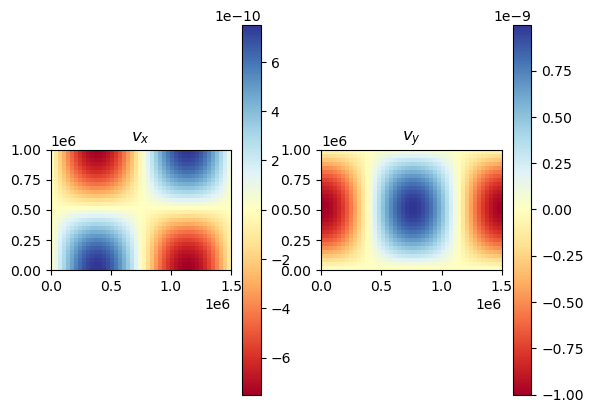

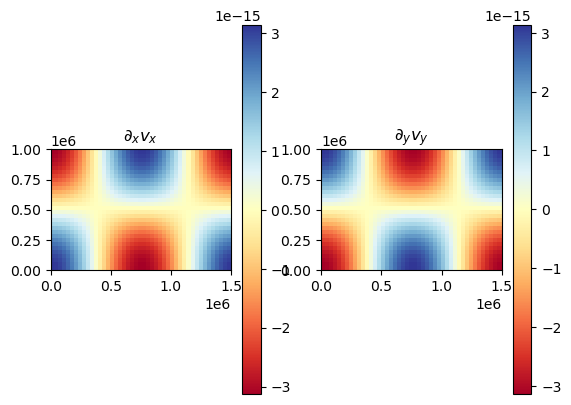

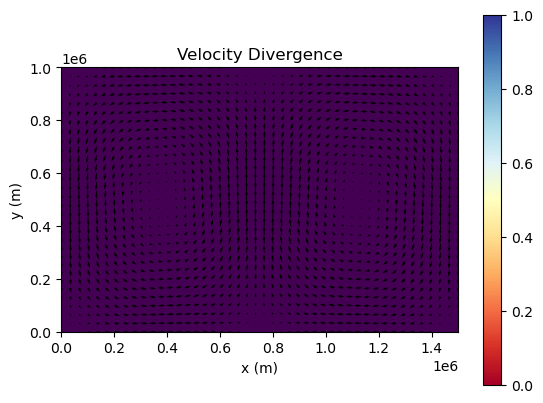

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/maxrudolph/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [3]:
# Note that this plotting code uses the interface to pyplot
colormap = get_cmap("RdYlBu")
figure()
subplot(1,2,1)
pcolor(x,y,vxp,cmap=colormap)
gca().set_aspect("equal")
colorbar()
title("\$v_x\$")
subplot(1,2,2)
pcolor(x,y,vyp,cmap=colormap)
gca().set_aspect("equal")
colorbar()
title("\$v_y\$")
show()

figure()
subplot(1,2,1)
pcolor(x,y,dvx_dxp,cmap=colormap)
gca().set_aspect("equal")
colorbar()
title("""\$\\partial_x v_x\$""")
subplot(1,2,2)
pcolor(x,y,dvy_dyp,cmap=colormap)
gca().set_aspect("equal")
colorbar()
title("""\$\\partial_y v_y\$""")
show()


figure()
pcolor(x,y,divvp)
gca().set_aspect("equal")
quiver(x,y,vxp,vyp,cmap=colormap)
title("Velocity Divergence")
xlabel("x (m)")
ylabel("y (m)")
colorbar()
show()

# Problem 2.2

In [11]:
# First, calculate the molar gibbe potential
m=0.0403044
function G_periclase(P,T)
    Pr=1e5 # Pascal
    Tr = 298.15 # Kelvin
    Hr = -601500.00 # Joule
    Vr = 1.12228e-5 # J/Pa
    phi = 30179500000. # Pa
    c = [1.96612,4.12756,0.53690]
    DH = [2966.88,5621.69,27787.19]
    DV = [3.52971e−8,3.52971e−8,1.9849568e−6]
    R = 8.3145 # J/mol/K

    Psi(P) = 5/4*(Pr+phi)^(1/5)*((P+phi)^(4/5)-(Pr+phi)^(4/5))
    ei(P,T,i) = exp(-(DH[i]+DV[i]*Psi(P))/(R*T) )
    eoi(P,T,i) = exp(-DH[i]/(R*Tr))
    gm = Hr + Vr*Psi(P)
    for i=1:3
        gm += c[i]*(R*T*log(1-ei(P,T,i)) - DH[i]*eoi(P,T,i)/(1-eoi(P,T,i)) )
    end
    return gm 
end

Pplot = LinRange(1e9,1e11,200)
Tplot = LinRange(100,4000,201)
Gmolar = [G_periclase(P,T) for P in Pplot, T in Tplot]
# P changes along rows, T along columns
dGdP = zeros(size(Gmolar))
for j = 1:length(Tplot)
    dGdP[1,j] = (Gmolar[2,j]-Gmolar[1,j])/(Pplot[2]-Pplot[1])
    for i in 2:length(Pplot)-1
        dGdP[i,j] = (Gmolar[i+1,j]-Gmolar[i-1,j])/(Pplot[i+1]-Pplot[i-1])
    end
    i=length(Pplot)
    dGdP[i,j] = (Gmolar[i,j]-Gmolar[i-1,j])/(Pplot[i]-Pplot[i-1])
end
rho = m./dGdP # dGdP is molar volume

# calculate compressibility (isothermal)
beta = zeros(size(rho))
for j = 1:length(Tplot)
    beta[1,j] = 1/rho[1,j]*(rho[2,j]-rho[1,j])/(Pplot[2]-Pplot[1])
    for i in 2:length(Pplot)-1
        beta[i,j] = 1/rho[i,j]*(rho[i+1,j]-rho[i-1,j])/(Pplot[i+1]-Pplot[i-1])
    end
    i=length(Pplot)
    beta[i,j]=1/rho[i,j]*(rho[i,j]-rho[i-1,j])/(Pplot[i]-Pplot[i-1])
end

alpha = zeros(size(rho))
for i=1:length(Pplot)
    alpha[i,1] = 1/rho[i,1] * (rho[i,1+1]-rho[i,1])/(Tplot[1+1]-Tplot[1])
    for j=2:length(Tplot)-1
        alpha[i,j] = 1/rho[i,j] * (rho[i,j+1]-rho[i,j-1])/(Tplot[j+1]-Tplot[j-1])
    end
    j=length(Tplot)
    alpha[i,j] = 1/rho[i,j] * (rho[i,j]-rho[i,j-1])/(Tplot[j]-Tplot[j-1])
end

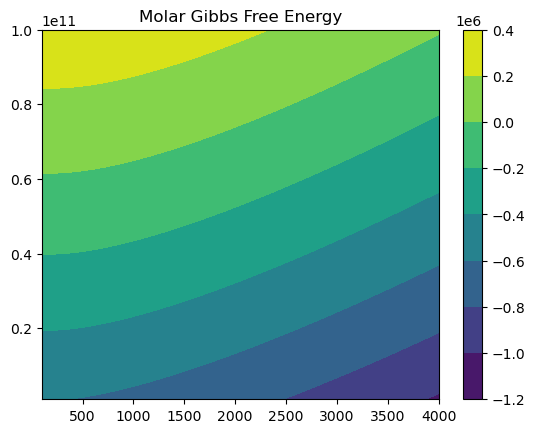

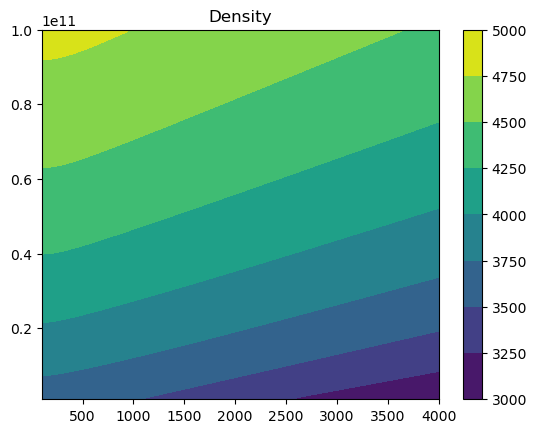

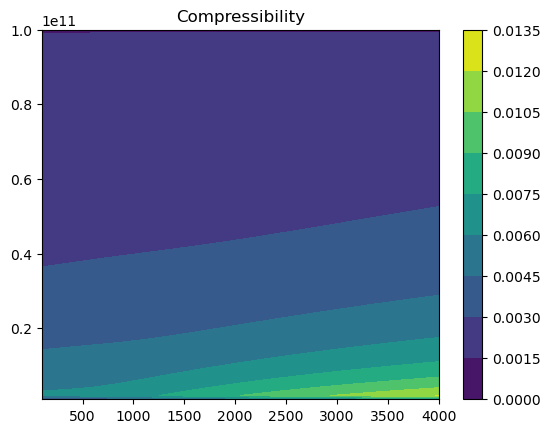

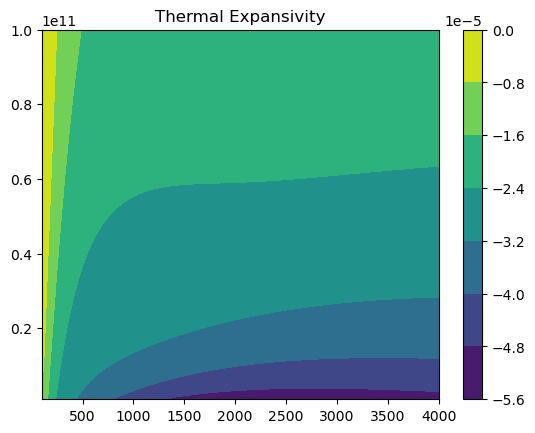

In [13]:
using PyPlot

figure()
p1 = PyPlot.contourf(Tplot,Pplot,Gmolar);
title("Molar Gibbs Free Energy")
colorbar()
show()
figure()
p2 = PyPlot.contourf(Tplot,Pplot,rho);
title("Density")
colorbar()
show()
figure()
p2 = PyPlot.contourf(Tplot,Pplot,beta*1e9);
title("Compressibility")
colorbar()
show()
figure()
p2 = PyPlot.contourf(Tplot,Pplot,alpha);
title("Thermal Expansivity")
colorbar()
show()


In [6]:
size(Gmolar)

(100, 101)

In [7]:
length(Pplot)

100